# Test 1

In [1]:
import mib as mb1
import mib_v2_3_1 as mb
import matplotlib.pyplot as plt
import time
import tracemalloc

## Planteamiento

Comprobar del rendimiento del motor de inferencia con problema pequeño y con tres eventon con distribuciones uniformes, donde su cardinalidad de los tres va de uno a cien.

### Variables

- $A = \{0, 2, ..., n-1\}$

- $B = \{0, 2, ..., n-1\}$

- $C = \{0, 2, ..., n-1\}$

### Modelo de descomposición

$P(ABC) = P(A)P(B|A)P(C|AB)$.

$\;\;\;\;\;\;\;\;\;\;\;\;$<img src="./P(ABC).jpg" width=200/>

### Formas 

$P(A)$, $P(B|A)$ y $P(C|AB)$ serán distribuciones uniformes.

## Test

### MIB1.0

In [55]:
n = 30
timesM1 = []
memoryM1 = []

timesC1 = []
memoryC1 = []

for i in range(21,22):
    Events = [x for x in range(i+1)]
    # Varaibles
    A = mb1.Var('A',Events)
    B = mb1.Var('B',Events)
    C = mb1.Var('C',Events)

    dA = {}
    dB_A = {}
    dC_AB = []
    value = 1 / (i+1)
    for e in Events:
        dA[e] = value
        dB_A[e] = {}
        for e1 in Events:
            dB_A[e][e1] = value
            tC_AB = []
            for e2 in Events:
                tC_AB.append(value)
            dC_AB.append(tuple(tC_AB))
    
    PA=mb1.Distrib(name='P(A)',variable=[A],tabla=dA)
    PB_A=mb1.DistribCond(name='P(B|A)',var=B,indep=[A],tabla=dB_A)
    PC_AB=mb1.DistribCond('P(C|AB)',C,[A,B],dC_AB)
    
    PABC=mb1.JointDistrib(name='P(ABC)',variables=[A,B,C],descomp=[PA,PB_A,PC_AB])
    Q_ABC=mb1.Question(joint=PABC)

    #Inferencia de P(B)
    tracemalloc.start()
    
    inicio = time.time()
    PB = Q_ABC.query(searched=[B])
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesM1.append(tiempo_ejecucion)
    memoryM1.append(memoria_pico)
    
    #Inferencia de P(A|BC)
    tracemalloc.start()
    
    inicio = time.time()
    PA_BC = Q_ABC.query(searched=[A], known=[B,C])
    fin = time.time() 
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesC1.append(tiempo_ejecucion)
    memoryC1.append(memoria_pico)

In [49]:
import json

# Diccionario que deseas guardar
mi_diccionario = {
    "timesM1": timesM1[:len(timesM1)-1],
    "timesC1": timesC1,
    "memoryM1": memoryM1[:len(timesM1)-1],
    "memoryC1": memoryC1
}

# Guardar el diccionario en un archivo JSON
with open("datosMIB1.json", "w") as archivo_json:
    json.dump(mi_diccionario, archivo_json, indent=4)

### MIB2.0

In [50]:
n = 25
timesM = []
memoryM = []

timesC = []
memoryC = []

for i in range(n):
    Events = set([x for x in range(i+1)])
    
    # Generación de distribuciones de probabilidad (Distribuciones uniformes).
    dA = {}
    dB_A = {}
    dC_AB = {}
    value = 1 / (i+1)
    for x in range(i+1):
        dA[(x,)] = value
        dB_A[(x,)] = {}
        for y in range(i+1):
            dB_A[(x,)][(y,)] = value
            dC_AB[(x,y)] = {}
            for z in range(i+1):
                dC_AB[(x,y)][(z,)] = value
    
    # Variables para el motor de inferencia.
    A = mb.Var('A', Events)
    PA = mb.Distrib(dA, (A.getName(),))
    B = mb.Var('B', Events)
    PB_A = mb.CondDistrib(dB_A, (B.getName(),), (A.getName(),))
    C = mb.Var('C', Events)
    PC_AB = mb.CondDistrib(dC_AB, (C.getName(),), (A.getName(),B.getName()))
    
    # Probabilidad conjunta (Espesificación)
    PABC = mb.Specification(set([A,B,C]), set([PA, PB_A, PC_AB]))

    Q_ABC = mb.Question(PABC)
    
    # Inferencia de una marginal
    tracemalloc.start()
    
    inicio = time.time()
    PB = Q_ABC.DistributionQuery(set([B]))
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tiempo_ejecucion = fin - inicio
    
    timesM.append(tiempo_ejecucion)
    memoryM.append(memoria_pico)
    
    # Inferencia de una condicional dada observaciones
    tracemalloc.start()
    
    inicio = time.time()
    PA_BC = Q_ABC.DistributionQuery(set([A]), set([B,C]))
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesC.append(tiempo_ejecucion)
    memoryC.append(memoria_pico)

## Datos obtenidos

### Tiempos

#### Tiempos de inferencia para $P(B)$

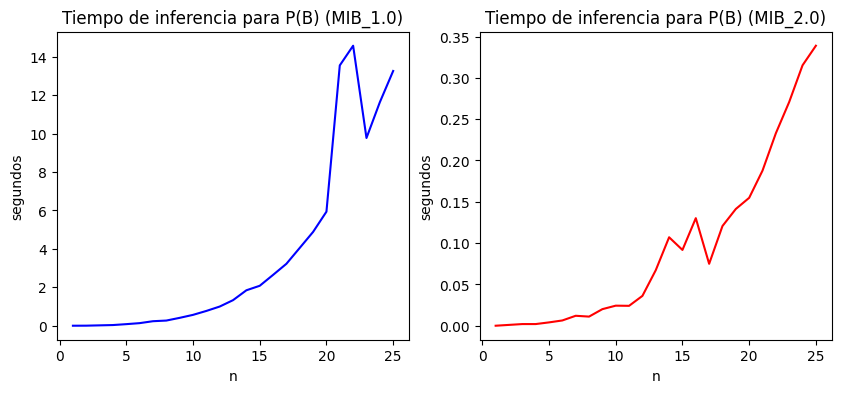

In [52]:
xn = [i+1 for i in range(n)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
# fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, timesM1[:len(timesM1)-1], color='b',label = 'MIB_1.0')
ax[0].set_title("Tiempo de inferencia para P(B) (MIB_1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("segundos")

# MIB_2.0
ax[1].plot(xn, timesM, color='r',label = 'MIB_2.0')
ax[1].set_title("Tiempo de inferencia para P(B) (MIB_2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("segundos")

# Mostrar las gráficas
plt.show()

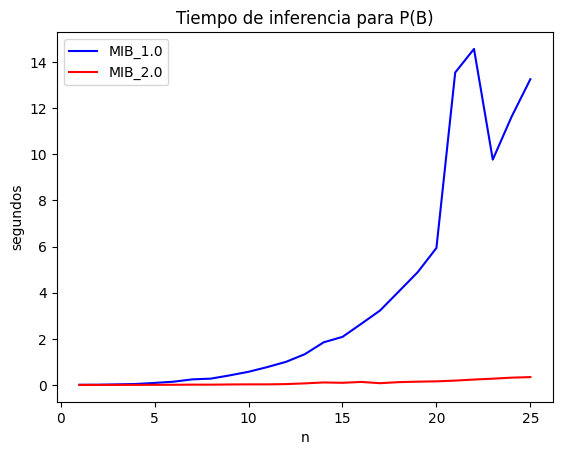

In [54]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, timesM1[:len(timesM1)-1], color='b', label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, timesM, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

#### Tiempos de inferencia para $P(C|AB)$

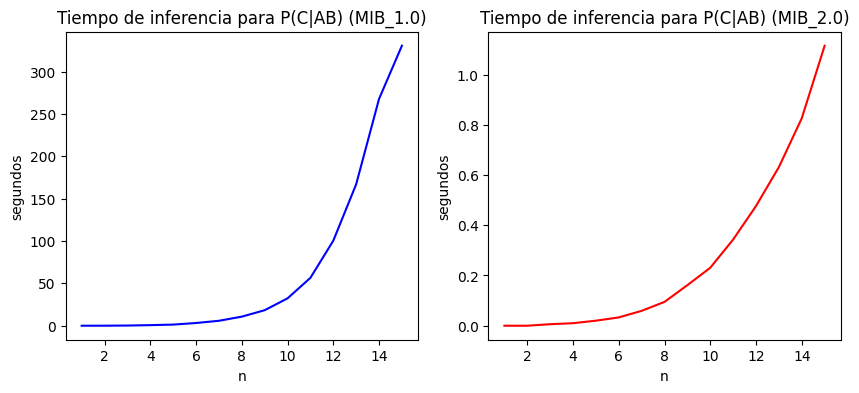

In [25]:
xn = [i+1 for i in range(n)]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10,4)
# MIB_1.0
ax[0].plot(xn, timesC1, color='b',label = 'MIB_1.0')
ax[0].set_title("Tiempo de inferencia para P(C|AB) (MIB_1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("segundos")

# MIB_2.0
ax[1].plot(xn, timesC, color='r',label = 'MIB_2.0')
ax[1].set_title("Tiempo de inferencia para P(C|AB) (MIB_2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("segundos")

# Mostrar las gráficas
plt.show()

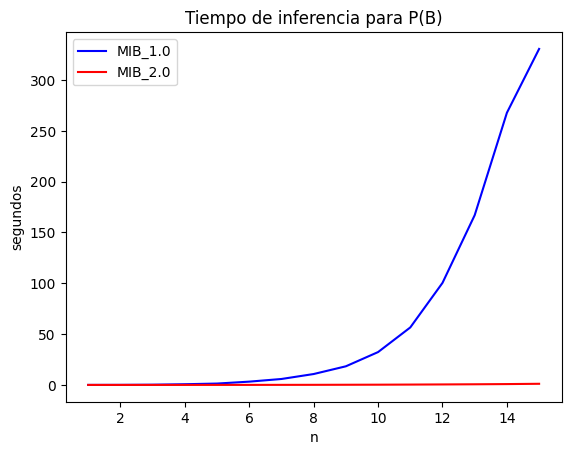

In [26]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, timesC1, color='b', label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, timesC, color='r',label = 'MIB_2.0')
ax.set_title("Tiempo de inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("segundos")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

### Memoria

#### Memoria para la inferencia de P(B)

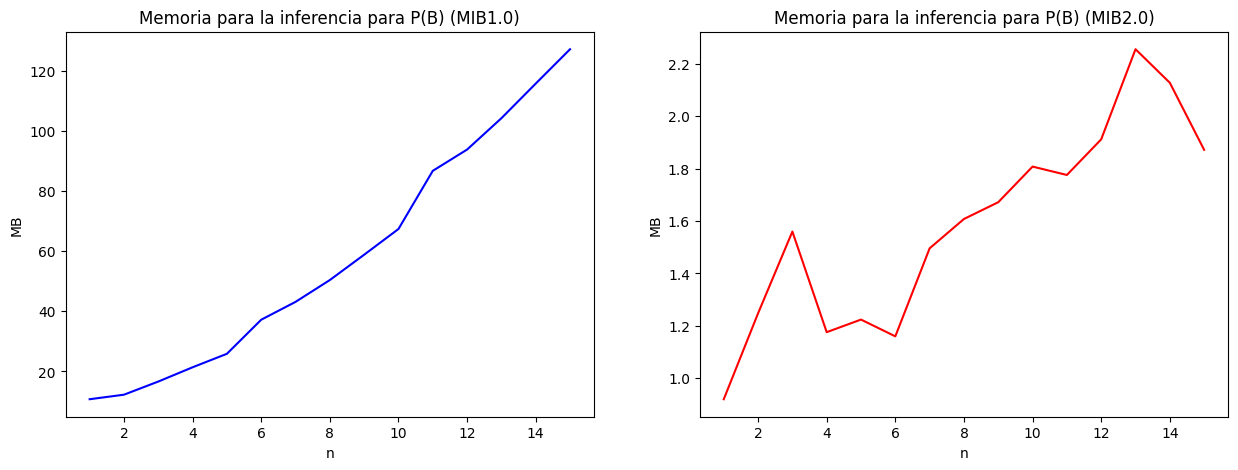

In [38]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, [m/1000 for m in memoryM1], color='b',label = 'MIB_1.0')
ax[0].set_title("Memoria para la inferencia para P(B) (MIB1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("MB")

# MIB_2.0
ax[1].plot(xn, [m/1000 for m in memoryM], color='r',label = 'MIB_2.0')
ax[1].set_title("Memoria para la inferencia para P(B) (MIB2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("MB")

# Mostrar las gráficas
plt.show()

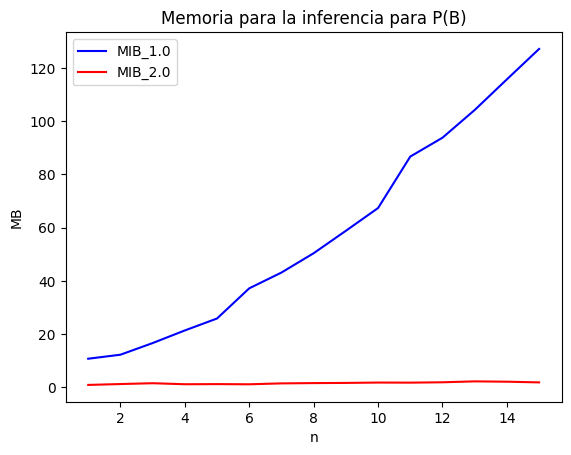

In [34]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, [m/1000 for m in memoryM1], color='b',label = 'MIB_1.0')

# MIB_2.0
ax.plot(xn, [m/1000 for m in memoryM], color='r',label = 'MIB_2.0')
ax.set_title("Memoria para la inferencia para P(B)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

#### Memoria para la inferencia de P(C|AB)

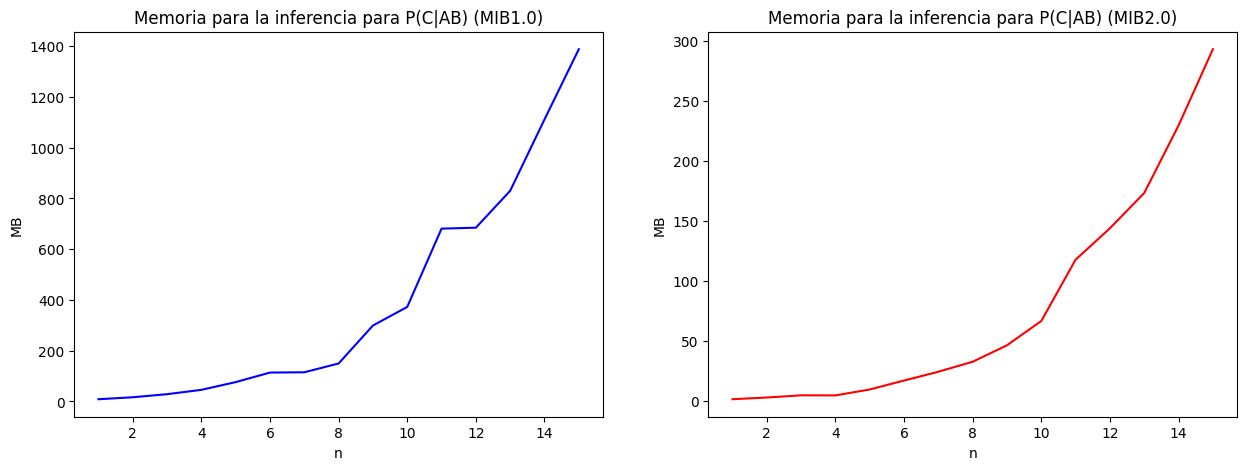

In [39]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15,5)
# MIB_1.0
ax[0].plot(xn, [m/1000 for m in memoryC1], color='b',label = 'MIB_1.0')
ax[0].set_title("Memoria para la inferencia para P(C|AB) (MIB1.0)")
ax[0].set_xlabel("n")
ax[0].set_ylabel("MB")

# MIB_2.0
ax[1].plot(xn, [m/1000 for m in memoryC], color='r',label = 'MIB_2.0')
ax[1].set_title("Memoria para la inferencia para P(C|AB) (MIB2.0)")
ax[1].set_xlabel("n")
ax[1].set_ylabel("MB")

# Mostrar las gráficas
plt.show()

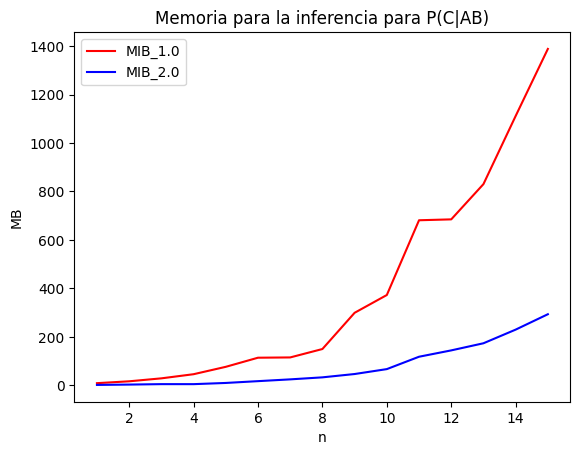

In [40]:
fig, ax = plt.subplots()

# MIB_1.0
ax.plot(xn, [m/1000 for m in memoryC1], color='r',label = 'MIB_1.0')
# MIB_2.0
ax.plot(xn, [m/1000 for m in memoryC], color='b',label = 'MIB_2.0')

ax.set_title("Memoria para la inferencia para P(C|AB)")

ax.set_xlabel("n")
ax.set_ylabel("MB")
ax.legend(loc = 'upper left')

# Mostrar las gráficas
plt.show()

# Test 2

In [ ]:
import mib as mb1
import mib_v2_3_1 as mb
import time

## Planteamineto

Se tiene un conjunto de correos, en los cuales se sabe si son spam o no, y se quiere saber si dada las palabras presentes en el correo el correo pertenece a spam.

### Variables

* $Spam := \{0,1\}$
* $W_i = \{0,1\}$

* $P(Spam = 0) = 0.25$
* $P(Spam = 1) = 0.75$

### Modelo de descomposición

$P(Spam W_0 W_1 ... W_n ) = P(Spam)\prod_i P(W_i|Spam)$.

Cada una de las $n$ formas de $P(W_i|Spam)$ debe ser espacificado. Para el conteo de la i-ésima palabra que aparesca spam y no spam 

* $P(W_i|Spam)$
    * $P(W_i = true | Spam = false) = \frac{1 + {n^i}_f}{|W_i| + n_f}$
    * $P(W_i = true | Spam = true) = \frac{1 + {n^i}_v}{|W_i| + n_t}$

donde, ${n^i}_f$ es el número de apariciones de la i-ésima palabra en correos que no son spam y $n_f$ es el número total de correos que no son spam, ${n^i}_v$ es el número de apariciones de la i-ésima palabra en correos que son spam y $n_v$ es el número total de correos que son spam.

## Implementación 

### Generación de distribuciones

#### $P(Spam)$

In [ ]:
dSpam = {(0,):0.25, (1,):0.75}
# Variables para el motor de inferencia.
Spam = mb.Var('Spam',set([0,1]))
PSpam = mb.Distrib(dSpam, (Spam.getName(),))
PSpam.print_table()

#### Variales $W_i$

In [ ]:
vocabulario = ['fortune','next','programming','money','you']
W = {}
events = set([0,1])

for palabra in vocabulario:
    W[palabra] = mb.Var(palabra, events)
    print(f'W[{palabra}]: {W[palabra]}')

In [ ]:
nif = [0,125,250,0,125] # Canitdad de veces que aparece una palabra en correos que no son spam.
niv = [375,0,0,750,375] # Canitdad de veces que aparece una palabra en correos que son spam.

nf = 250
nv = 750

PWi_Spam = {}

i = 0
for Wi in W:
    tf = (1 + nif[i]) / (2 + nf)
    tt = (1 + niv[i]) / (2 + nv)
    dWi_Spam = {(0,): {(0,): 1 - tf, (1,):  tf},
                (1,): {(0,): 1 - tt, (1,): tt}}
    
    PWi_Spam[Wi] = mb.CondDistrib(dWi_Spam, (W[Wi].getName(),), (Spam.getName(),))
    i += 1
for Wi in W:   
    PWi_Spam[Wi].print_table()

### Generación de pregunta

In [ ]:
vars = set([W[i] for i in W] + [Spam])
distribs = set([PWi_Spam[i] for i in W] + [PSpam])
P_WiSpam = mb.Specification(vars, distribs)
Q_WiSpam = mb.Question(P_WiSpam)

### Consulta

In [ ]:
inicio = time.time()
PSpam_wn = Q_WiSpam.DistributionQuery(set([Spam]), set([W[wi] for wi in W]))
fin = time.time()
tiempo_ejecucion = fin - inicio
PSpam_wn.print_table()

In [ ]:
tiempo_ejecucion

# Test 3

In [ ]:
import mib as mb1
import mib_v2_3_1 as mb

## Planteamiento

Una compañía sabe que la contratación profesional de un candidato se efectúa luego de una entrevista, que se lleva a cabo en función de las calificaciones reportadas en el certificado del candidato y si éste tiene experiencia laboral o no. Generalmente, sólo se consideran los candidatos con calificaciones sobresalientes o regulares, y la entrevista arroja típicamente tres tipos de apreciación.

La compañía ha elaborado el siguiente modelo de contratación:

$\;\;\;\;\;\;\;\;\;\;\;\;$<img src="./MODELO_EMPRESA.jpg" width=300/>

La compañía ha recolectado datos históricos de los últimos 5 años sobre la evaluación de 500 candidatos y sabe que la proporción de candidatos con calificaciones regulares es del 30%, mientras que los candidatos con experiencia laboral representan el 60%. En la mejor condición, con calificaciones sobresalientes y experiencia laboral, los candidatos obtienen la más alta apreciación en la entrevista en un 80%, y la peor apreciación en un 2% de los casos. Estos porcentajes cambian respectivamente a 30% y 10% cuando las calificaciones no son las mejores, pero sí hay experiencia, y ambas son del 30% con calificaciones sobresalientes pero sin experiencia. En el peor caso, con calificaciones regulares y sin experiencia, los candidatos obtienen la mejor apreciación en la entrevista en un 10% y la peor en un 70%. Por último, se sabe que la tasa de candidatos rechazados es de un 10% cuando obtienen una apreciación favorable, un 60% cuando obtienen una apreciación regular, y un 99% cuando obtienen una apreciación desfavorable en la entrevista.

### Variables

* $C := \{0,1\}$, donde C representa las calificaciones; 0 si son calificaciones reguales, 1 otro caso.
* $E : = \{0,1\}$, donde E representa la experencia; 
* $N : = \{0,1,2\}$, donde  
* $O : = \{0,1\}$, donde

### Modelo de descomposición

$P(C E N O) = P(C)P(E)P(N|C E)P(N|O)$

## Implementación

In [ ]:
E = mb.Var('E', set([0,1]))
C = mb.Var('C', set([0,1]))
O = mb.Var('O', set([0,1]))
N = mb.Var('N', set([0,1,2]))

dE = {(0,):0.4, (1,):0.6}
dC = {(0,):0.3, (1,):0.7}
dN_EC = {(0,0):{(0,):0.7, (1,):0.2, (2,):0.1},
        (0,1):{(0,):0.3, (1,):0.4, (2,):0.3},
        (1,0):{(0,):0.1, (1,):0.6, (2,):0.3},
        (1,1):{(0,):0.02, (1,):0.18, (2,):0.8}}
dO_N={(0,):{(0,):0.99, (1,):0.01},
      (1,):{(0,):0.6, (1,):0.4},
      (2,):{(0,):0.1, (1,):0.9}}

P_E = mb.Distrib(dE, (E.getName(),))
P_C = mb.Distrib(dC, (C.getName()))
P_N_EC = mb.CondDistrib(dN_EC, (N.getName(),), (E.getName(), C.getName()))
P_O_N = mb.CondDistrib(dO_N, (O.getName(),), (N.getName()))

### Creación de la especificación

In [ ]:
vars = set([E,C,N,O])
P_ECNO = mb.Specification(vars,set([P_E,P_C,P_N_EC,P_O_N]))
Q_P = mb.Question(P_ECNO)

### Preguntas

In [ ]:
#1. Cuál es su tasa de contratación 
#(i.e. cuál es la probabilidad de ser contratado). P(O)
CONT = Q_P.Query(vars=(O,), vars_values = (1,))
print(f'{round(CONT*100,2)}%')

In [ ]:
#2. Cuantos candidatos ha contratado la compañía en los últimos 5 años. 
#X=P(O=0)*500.
from math import floor

X = floor(500*CONT)
print(X)

In [ ]:
#3. Cuál es la tasa de apreciaciones favorables en la compañía.
PN = Q_P.DistributionQuery(set(N))
PN.print_table()
FAV = Q_P.Query(vars=(N,), vars_values = (2,))
print(f'{FAV*100}%')

In [ ]:
#4. Cuál es la tasa de apreciaciones regulares dado que se contrata a alguien. 
TAF = Q_P.Query(vars=(N,), indep=(O,), vars_values = (1,), indep_values=(0,))
print(f'{TAF*100}%')

In [ ]:
#5. Cuál es la tasa de apreciaciones regulares dado que se contrata a alguien.
TAF = Q_P.Query(vars=(N,), indep=(O,), vars_values = (0,), indep_values=(0,))
print(f'{int(round(TAF*X,0))}')

In [ ]:
#6. Cuantos de los candidatos contratados obtuvieron una apreciación regular. 
#P(N=1|O=0)*X
print(floor(TAF*X))

In [ ]:
#7. Cómo se distribuye la contratación de candidatos en función de sus calificaciones. 

PO_C = Q_P.DistributionQuery(set([O]),set([C]))
PO_C.table

In [ ]:
#8. Cómo se distribuye la contratación de candidatos en función de su experiencia. 

PO_E = Q_P.DistributionQuery(set([O]),set([E]))
PO_E.table

In [ ]:
#9. Cuál es la probabilidad de que alguien con experiencia laboral tenga calificaciones sobresalientes. 
#P(C=0|E=0)
ECS = Q_P.Query(vars=(C,), indep=(E,), vars_values = (0,), indep_values=(0,))
print(f'{ECS*100}%')

In [ ]:
#10. Cuál es la distribución conjunta del personal contratado y 
#la apreciación de la entrevista.
PON = Q_P.DistributionQuery(set([N,O]))
PON.table

# Test 4

In [1]:
import tpproc as tp
from collections import Counter  #regresa un diccionario con conteos
import glob
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import OrderedDict #diccionarios ordenados
import numpy as np
from itertools import product
import mib_v2_3_1 as mb

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rober\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rober\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Planteamiento

**Problema de autoria de textos**

## Especificación 

### Variables
- $A$ : Variable para los autores
- $T$ : Variable para los tipos de textos
- $W_I$ : Variable para las palabras

**Variable $A$**

- $A = $ Alfonso Reyes
- $A = $ Esopo
- $A = $ Fuentes
- $A = $ García Márquez
- $A = $ Gibran
- $A = $ La Fontanie
- $A = $ Onetti
- $A = $ Quiroga
- $A = $ Rulfo
- $A = $ Saramago

**Variable $T$**

- $T = $ minicuento
- $T = $ cuento
- $T = $ fábula

**Variable $W_i$**

- $W_i = \{0,1\}$, donde cada $W_i$ representa una variable para una palabra y sus representaciones númericas son las siguientes:
- $W_i = 0$ -> la palabra no esta.
- $W_i = 1$ -> la palabra si esta.

### Suponiendo un modelo de descomposición exacta:

$P(A)P(T|A)\displaystyle \prod_{i=0}^{n} P(W_i|AT)$

## Implementación

### Obtención de datos para el test

In [14]:
archivos = glob.glob('./Train/*/*')
archivos,nombres = tp.carga_cuentos(archivos)
df_train = tp.lee_cuentos(archivos)
df_train.head()

leyendo...
tamaño del contenido de archivos cargados:             1 KB


,titulo,tipo,autor,texto
0,catástrofes,minicuento,alfonso reyes,pasa hablado cierta catástrofe cósmica amenaza...
1,del perfecto gobernante,minicuento,alfonso reyes,entiende perfecto gobernante perfecto lleno pe...
2,ley profunda,minicuento,alfonso reyes,trata libertarnos simplemente enseñarnos descu...
3,los alivios,minicuento,alfonso reyes,nombres usan castellano restroom impropios bañ...
4,el buen rey león,fábula,esopo,león enojoso cruel violento sino tratable just...


In [15]:
archivos = glob.glob('./Test/*')
archivos,nombres = tp.carga_cuentos(archivos)
df_test = tp.lee_cuentos(archivos,test=True)
df_test.head()

leyendo...
tamaño del contenido de archivos cargados:             0 KB


,titulo,texto
0,divina fragilidad,dios creó universo sentía solo eternidad empez...
1,dos seres iguales,cierto día profeta sharía encontró niña jardín...
2,el caballo y el lobo,estación blandos céfiros hacen verdear campos ...
3,el cetro,dijo rey esposa señora verdaderamente reina de...
4,el impostor,cansada esperar hombre llegó puntual sonreírme...


#### Data Frames de trabajo

In [16]:
s = df_train.texto.str.cat(sep=' ').split()
print(len(s))
conteos=Counter(s)
nuevo_vocabulario = list(set([palabra for palabra in s if conteos[palabra] <= 20 and conteos[palabra] >= 1]))
print(len(nuevo_vocabulario))

7210
3915


In [17]:
df_train_T = df_train.copy()
df_train_T['nuevo_texto'] = df_train_T.texto.str.split().\
    apply(lambda texto: [w for w in texto if w in nuevo_vocabulario]).\
    apply(lambda x : ' '.join(x))
df_train_T['Conteos']=df_train_T.nuevo_texto.str.split().apply(Counter)


df_train_T.head()

,titulo,tipo,autor,texto,nuevo_texto,Conteos
0,catástrofes,minicuento,alfonso reyes,pasa hablado cierta catástrofe cósmica amenaza...,pasa hablado cierta catástrofe cósmica amenaza...,"{'pasa': 1, 'hablado': 1, 'cierta': 1, 'catást..."
1,del perfecto gobernante,minicuento,alfonso reyes,entiende perfecto gobernante perfecto lleno pe...,entiende perfecto gobernante perfecto lleno pe...,"{'entiende': 1, 'perfecto': 3, 'gobernante': 4..."
2,ley profunda,minicuento,alfonso reyes,trata libertarnos simplemente enseñarnos descu...,trata libertarnos simplemente enseñarnos descu...,"{'trata': 1, 'libertarnos': 1, 'simplemente': ..."
3,los alivios,minicuento,alfonso reyes,nombres usan castellano restroom impropios bañ...,nombres usan castellano restroom impropios bañ...,"{'nombres': 1, 'usan': 1, 'castellano': 1, 're..."
4,el buen rey león,fábula,esopo,león enojoso cruel violento sino tratable just...,león enojoso cruel violento sino tratable just...,"{'león': 1, 'enojoso': 1, 'cruel': 1, 'violent..."


In [18]:
s=df_test.texto.str.cat(sep=' ').split()
print(len(s))
conteos=Counter(s)
nuevo_vocab = list(set([palabra for palabra in s if conteos[palabra] <= 20 and conteos[palabra] >= 1]))
print(len(nuevo_vocab))

2224
1435


In [19]:
df_test_T = df_test.copy()
df_test_T['nuevo_texto']=df_test_T.texto.str.split().\
    apply(lambda texto: [w for w in texto if w in nuevo_vocab]).\
    apply(lambda x : ' '.join(x))
df_test_T['nuevo_total']=df_test_T.nuevo_texto.str.split().apply(len)
df_test_T['Conteos']=df_test_T.nuevo_texto.str.split().apply(Counter)


df_test_T.head()

,titulo,texto,nuevo_texto,nuevo_total,Conteos
0,divina fragilidad,dios creó universo sentía solo eternidad empez...,dios creó universo sentía solo eternidad empez...,174,"{'dios': 9, 'creó': 1, 'universo': 3, 'sentía'..."
1,dos seres iguales,cierto día profeta sharía encontró niña jardín...,cierto día profeta sharía encontró niña jardín...,131,"{'cierto': 1, 'día': 3, 'profeta': 7, 'sharía'..."
2,el caballo y el lobo,estación blandos céfiros hacen verdear campos ...,estación blandos céfiros hacen verdear campos ...,111,"{'estación': 1, 'blandos': 1, 'céfiros': 1, 'h..."
3,el cetro,dijo rey esposa señora verdaderamente reina de...,dijo rey esposa señora verdaderamente reina de...,62,"{'dijo': 3, 'rey': 3, 'esposa': 2, 'señora': 1..."
4,el impostor,cansada esperar hombre llegó puntual sonreírme...,cansada esperar hombre llegó puntual sonreírme...,169,"{'cansada': 1, 'esperar': 1, 'hombre': 2, 'lle..."


#### Tamaño del vocabulario conjunto (total de palabras)

In [20]:
vocabulario = list(set(nuevo_vocabulario+nuevo_vocab))
print(len(vocabulario))

4757


In [21]:
voc_dict = OrderedDict(zip(vocabulario,range(len(vocabulario))))
v = list(voc_dict.keys())

#### Conteos

In [22]:
# Ocurrencias de cada autor y conteos de ocurrencias y de número de autores
oc_autor = Counter(df_train_T.autor)
tot_oc_aut = np.sum(list(oc_autor.values()))
tot_autores = len(oc_autor)

# Ocurrencias de cada tipo y conteos de ocurrencias y de número de tipos
oc_tipo = Counter(df_train_T.tipo)
tot_oc_tipo = np.sum(list(oc_tipo.values()))
tot_tipos = len(oc_tipo)

### Creación de variables

In [23]:
# Autor
autor_val = dict(zip(oc_autor.keys(),range(len(oc_autor.keys()))))
val_autor = dict(zip(range(len(oc_autor.keys())),oc_autor.keys()))
A = mb.Var('A',set(oc_autor.keys()))
# Tipos
tipo_val = dict(zip(oc_tipo.keys(),range(len(oc_tipo.keys()))))
val_tipo = dict(zip(range(len(oc_tipo.keys())),oc_tipo.keys()))
T = mb.Var('T',set(oc_tipo.keys()))

# Palabras
W = {}
for w in voc_dict:    # vocabulario reducido
    W[w] = mb.Var(w,set([0,1]))

### Identificación de parámetros (estadísticas)

### Método:

1. Descomposición exacta: $P(A)P(T|A)P(W|AT)$
2. Calcular las estadísticas por cada distribución de la descomposición
3. Para la variable Autor $P(A)$:
    - 3.1 Contar el número total de ocurrencias de autores en Train: $n_a$.
    - 3.2 Contar el número de ocurrencias de cada autor en Train: $n^i$.
    - 3.3 Dividir este número entre el número total de ocurrencias de autores en Train: $\displaystyle \frac{n^i}{n_a}$.
4. Para la variable Tipo $P(T|A)$:
    - 4.1 Obtener el conjunto de autores (valores únicos) $a$; entradas a la Tabla.
    - 4.2 Obtener el conjunto de tipos (valores únicos) $j$; estas son las salidas de la Tabla.
    - 4.3 Calcular el producto cartesiano de las combinaciones posibles (a,j).
    - 4.4 Contar el número de ocurrencias totales de cada $j$ por cada autor: $n^j_a$.
    - 4.5 Dividir este número entre el número total de tipos por autor: $\displaystyle \frac{n^j_a}{\sum n^j_a}$.
    - 4.6 Aplicar la corrección de Laplace para evitar probabilidades en $0$.
5. Para las variables W (palabras) $P(W|AT)$: **NOTA** se trata de calcular N Tablas, donde N es el tamaño del vocabulario.
    - 5.1 Calcular el producto cartesiano de las combinaciones posibles (a,j); estas son las entradas a cada Tabla.
    - 5.2 Por cada combinación, calcular la probabilidad de cada palabra del vocabulario, en función de su ocurrencia en esa combinación, aplicando la corrección de Laplace. 

##### Distribución P(A)

- Contar el número total de ocurrencias de autores en Train: $n_a$: _tot_oc_aut_
- Contar el número de ocurrencias de cada autor en Train: $n^i$: _oc_autor_ 
- Dividir este número entre el número total de ocurrencias de autores en Train: $\displaystyle \frac{n^i}{n_a}$

In [24]:
n_= []
for autor in oc_autor:
    n_.append(((autor,),oc_autor[autor]/tot_oc_aut))

#Dicionario de valores de probabilidad
dA = dict(n_)
#Distribución de probabilidad
PA = mb.Distrib(table = dA, columns=('A',))
print(A.getValues())
PA.print_table()

['esopo', 'carlos fuentes', 'juan rulfo', 'alfonso reyes', 'jean de la fontaine', 'gibrán jalil gibrán', 'juan carlos onetti', 'gabriel garcía márquez', 'horacio quiroga', 'josé saramago']
{('alfonso reyes',): np.float64(0.13333333333333333), ('esopo',): np.float64(0.1), ('carlos fuentes',): np.float64(0.06666666666666667), ('gabriel garcía márquez',): np.float64(0.13333333333333333), ('gibrán jalil gibrán',): np.float64(0.16666666666666666), ('jean de la fontaine',): np.float64(0.13333333333333333), ('juan carlos onetti',): np.float64(0.06666666666666667), ('horacio quiroga',): np.float64(0.06666666666666667), ('juan rulfo',): np.float64(0.06666666666666667), ('josé saramago',): np.float64(0.06666666666666667)}


#### Distribución P(T|A)

   - Obtener el conjunto de autores (valores únicos) $a$; entradas a la Tabla: _df_train.autor_
   - Obtener el conjunto de tipos (valores únicos) $j$; estas son las salidas de la Tabla: _df_train.tipo_ 
   - Calcular el producto cartesiano de las combinaciones posibles (a,j): _pares_ta_
   - Contar el número de ocurrencias totales de cada $j$ por cada autor: $n^j_a$: _conteo_pares_
   - Dividir este número entre el número total de tipos por autor: $\displaystyle \frac{n^j_a}{\sum n^j_a}$.
   - Aplicar la corrección de Laplace para evitar probabilidades en $0$.

In [26]:
# Ocurrencias (conteos) de cada combinación (tipo,autor)
conteo_pares = Counter(zip(df_train_T.autor,df_train_T.tipo))
# print(conteo_pares)

# Combinaciones (tipo,autor)
autores = list(set(df_train_T.autor))
tipos = list(set(df_train_T.tipo))

dT_A = {}

for autor, tipo in product(*[autores,tipos]):
    par = (autor, tipo)
    ak = (autor,)
    
    if ak in dT_A.keys():
        if par in conteo_pares.keys():
            dT_A[ak][(tipo,)] = conteo_pares[par]
        else:
            dT_A[ak][(tipo,)] = 0 
    else:
        if par in conteo_pares.keys():
            dT_A[ak] = {(tipo,): conteo_pares[par]}
        else:
            dT_A[ak] = {(tipo,): 0}


# Corrección de Laplace en el caso general
# Se corrige la misma tabla que se senvía como argumento; no se crea una nueva.
def Laplace_gral(tabla):
    n = len(tabla[list(tabla.keys())[0]]) 
    for k in tabla.keys():
        registro = tabla[k]
        n_j = np.sum(list(registro.values()))
        for i in registro.keys():
            pb = (registro[i] + 1)/(n_j+n)
            tabla[k][i]=pb
    return

Laplace_gral(dT_A)

PT_A = mb.CondDistrib(dT_A, (T.getName(),), (A.getName(),))

In [27]:
PT_A.print_table()

{('esopo',): {('fábula',): np.float64(0.6666666666666666), ('cuento',): np.float64(0.16666666666666666), ('minicuento',): np.float64(0.16666666666666666)}, ('carlos fuentes',): {('fábula',): np.float64(0.2), ('cuento',): np.float64(0.4), ('minicuento',): np.float64(0.4)}, ('juan rulfo',): {('fábula',): np.float64(0.2), ('cuento',): np.float64(0.6), ('minicuento',): np.float64(0.2)}, ('alfonso reyes',): {('fábula',): np.float64(0.14285714285714285), ('cuento',): np.float64(0.14285714285714285), ('minicuento',): np.float64(0.7142857142857143)}, ('jean de la fontaine',): {('fábula',): np.float64(0.14285714285714285), ('cuento',): np.float64(0.14285714285714285), ('minicuento',): np.float64(0.7142857142857143)}, ('gibrán jalil gibrán',): {('fábula',): np.float64(0.125), ('cuento',): np.float64(0.625), ('minicuento',): np.float64(0.25)}, ('juan carlos onetti',): {('fábula',): np.float64(0.2), ('cuento',): np.float64(0.6), ('minicuento',): np.float64(0.2)}, ('gabriel garcía márquez',): {('fá

#### $P(W|AT)$

   - Calcular el producto cartesiano de las combinaciones posibles (a,j); estas son las entradas a cada Tabla.
   - Por cada combinación, calcular la probabilidad de cada palabra del vocabulario, en función de su ocurrencia en esa combinación, aplicando la corrección de Laplac

* Las palabras a tomar en cuenta son las del vocabulario.
* Se deben codificar las combinaciones (a,t) en valores numéricos.
* Por cada combinación (a,t):
    - si existe una historia (nuevo_texto), entonces cada palabra de este cuento está presente, y el resto de las palabras del vocabulario están ausentes.
    - si no hay historia, entonces ninguna palabra del vocabulario está presente --> Probabilidad 0 para todo el vocabulario.
* Al aplicar la corrección de Laplace, evitamos que una combinación (a,t), que por ahora no tiene texto, se considere imposible, al asignarle una probabilidad mínima a cada palabra del vocabulario.
* Para facilitar el "conteo" (presencia/ausencia) haremos un diccionario del vocabulario, incialmente en ceros

In [28]:
# Combinaciones (tipo,autor)
autores = list(set(df_train_T.autor))
tipos = list(set(df_train_T.tipo))
pares_ta = list(product(autores,tipos))

# Conteos de palabras en nuevo_texto por pares (a,t) en el data frame de train
conteo_w = dict(df_train_T.Conteos)
pares_train = list(zip(df_train_T.autor,df_train_T.tipo))

for i,k in enumerate(conteo_w.keys()):
    conteo_w[k] = {pares_train[i] : dict(conteo_w[k])}
    
def check(palabra,pares_ta):
    pw_ = {}
    var = W[palabra]
    
    for par in pares_ta:
        cw_1 = 0   # conteos de presencia 
        cw_0 = 0   # y ausencia en 0
        it = 0     # total de pares (a,t) contabilizados
        
        for item in list(conteo_w.values()):  # checamos cada par (a,t) en el conjunto de train
            # print(i,list(item.keys())[0], end=' ')
            it += 1
            if par in item: # checamos si el par (a,t) de entrada tiene correspondencia en Train
                if palabra in list(item.values())[0]: #checamos si la palabra existe en el par (a,t) de Train
                    cw_1 += 1
                else:
                    cw_0 += 1  #debemos contar también la no existencia por si hay igualdad
        
        if cw_0 == cw_1: # la palabra aparece por igual en todos los pares Train, o bien, no hay pares Train
            pw_1 = 0.5   #corrección de Laplace que indica que la palabra puede o no estar por igual
            pw_0 = 0.5
            
        else:
            pw_1=(1+cw_1)/(len(var.getValues())+it) #corrección de Laplace en caso de que la palabra exista
            pw_0 = 1-pw_1
        
        pw_[par] = {(0,): pw_0, (1,): pw_1}
    pw_ = OrderedDict(sorted(pw_.items()))
    return pw_
        
    
PW_AT = {}
for w in voc_dict:    # vocabulario reducido
    t = check(w,pares_ta)
    PW_AT[w] = mb.CondDistrib(dict(t), (W[w].getName(),), (A.getName(), T.getName()))

In [29]:
palabra = list(PW_AT.keys())[0]
print(palabra+':')
PW_AT[list(PW_AT.keys())[0]].print_table()

amistades:
{('alfonso reyes', 'cuento'): {(0,): 0.5, (1,): 0.5}, ('alfonso reyes', 'fábula'): {(0,): 0.5, (1,): 0.5}, ('alfonso reyes', 'minicuento'): {(0,): 0.96875, (1,): 0.03125}, ('carlos fuentes', 'cuento'): {(0,): 0.9375, (1,): 0.0625}, ('carlos fuentes', 'fábula'): {(0,): 0.5, (1,): 0.5}, ('carlos fuentes', 'minicuento'): {(0,): 0.96875, (1,): 0.03125}, ('esopo', 'cuento'): {(0,): 0.5, (1,): 0.5}, ('esopo', 'fábula'): {(0,): 0.96875, (1,): 0.03125}, ('esopo', 'minicuento'): {(0,): 0.5, (1,): 0.5}, ('gabriel garcía márquez', 'cuento'): {(0,): 0.96875, (1,): 0.03125}, ('gabriel garcía márquez', 'fábula'): {(0,): 0.5, (1,): 0.5}, ('gabriel garcía márquez', 'minicuento'): {(0,): 0.96875, (1,): 0.03125}, ('gibrán jalil gibrán', 'cuento'): {(0,): 0.96875, (1,): 0.03125}, ('gibrán jalil gibrán', 'fábula'): {(0,): 0.5, (1,): 0.5}, ('gibrán jalil gibrán', 'minicuento'): {(0,): 0.96875, (1,): 0.03125}, ('horacio quiroga', 'cuento'): {(0,): 0.96875, (1,): 0.03125}, ('horacio quiroga', 'fáb

In [30]:
vl =  [A,T] + [W[w] for w in W] 
dl = [PA,PT_A] + [PW_AT[w] for w in PW_AT]
vars_set = set(vl)
dist_set = set(dl)

## Pregutas 

In [31]:
PATWi = mb.Specification(vars_set, dist_set)
QW_AT = mb.Question(PATWi)

### 1. ¿Quién escribió "El caballo y el Lobo"?

In [32]:
dcont = df_test_T.loc[df_test['titulo'] == 'el caballo y el lobo', 'Conteos'].iloc[0]
wit = []
for w in dcont:
    wit.append(w)

In [33]:
values_wi = []
for w in W:
    if w in wit:
        values_wi.append(1)
    else:
        values_wi.append(0)

- $W = \text{ todas las palabras}$
- $Wt = \text{ palabras que esten en el texto}$
- $Wnt = \text{ palabras que no esten en el texto}$
- $W_i = 0 \text{ si } w_i \in wnt$
- $W_i = 1 \text{ si } w_i \in wt$

**Pregunta:**
$ P(A | W_0, W_1, \dots, W_n) $, donde se busca el valor más probable de $A$.

In [35]:
CA, VA, p = QW_AT.Query(vars=(A,), indep=tuple([W[w] for w in W]), indep_values=tuple(values_wi))
VA, p

(('esopo',), np.float64(4.305734698811897e-225))

## Tests de rendimiento 

### Simulación

In [ ]:
import mib_v2_3 as mb2_3
import mib_v2_3_thr as mb2_3tr
from itertools import product
import time

time_Q_TAW_nv = []

for i in [10,11,12,13]:
    time_Q_TAW = []

    A = mb2_3.Var('A', set([j for j in range(10)]))
    T = mb2_3.Var('T', set([0,1,2]))
    W = [mb2_3.Var(j, set([0,1])) for j in range(i)]
    
    print("n_vocab: ",i)
    dA = {}
    for j in range(10):
        dA[(j,)] = 1/10
        
    PA = mb2_3.Distrib(dA, ('A'))
    
    
    dT_A = {}
    for j in range(10):
        dT_A[(j,)] = {}
        for k in range(3):
            dT_A[(j,)][(k,)] = 1/10
        
    PT_A = mb2_3.CondDistrib(dT_A, ('T',), ('A'))
    
    PW_AT = []
    for wi in W:
        dwi_TA = {}
        for par in product(*[[0,1,2], [j for j in range(10)]]):
            dwi_TA[par] = {}
            for j in range(2):
                dwi_TA[par][(j,)] = 0.5

        PWi_AT = mb2_3.CondDistrib(dwi_TA, (wi.getName(),), ('T','A'))
        PW_AT.append(PWi_AT)
    
    set_vars = set([A,T] + W)
    set_descomp = set([PA, PT_A,] + PW_AT)
    PATW = mb2_3.Specification(set_vars,set_descomp)
    
    QW_AT = mb2_3.Question(PATW)
    
    for j in range(i):
        Wt = [W[k-1] for k in range(j+1)]
        Wt_v = [1 for k in range(j+1)]
        
        inicio = time.time()
        CA, VA, p = QW_AT.Query(vars=(A,), indep=tuple(Wt), values_indep=tuple(Wt_v))
        fin = time.time()
        print("n_w:",j,"-",fin - inicio)
        time_Q_TAW.append(fin - inicio)
    
    time_Q_TAW_nv.append(time_Q_TAW)

In [ ]:
import matplotlib.pyplot as plt
nc = 2
nf = 2
fig, axs = plt.subplots(nc, nf)
fig.set_size_inches(10,8)
f = 0
c = 0
for i,t in enumerate(time_Q_TAW_nv):
    xn = [k+1 for k in range(len(t))]
    axs[c,f].plot(xn, t)
    axs[c,f].set_title("P(A|W0,...,Wr) con n = {n}".format(n = len(t)))

    axs[c,f].set_xlabel("r")
    axs[c,f].set_ylabel("segundos")
    
    if f == nf - 1:
        f = 0
        if c == nc - 1:
            c = 0
        else:
            c += 1
    else:
        f += 1

### Test de $P(A|W_0,W_1,\dots,W_n)$ y $P(A|W_0,W_1,\dots,W_r,W_{r+1},\dots,W_n)$

In [1]:
import tpproc as tp
from collections import Counter  #regresa un diccionario con conteos
import glob
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import OrderedDict #diccionarios ordenados
import numpy as np
import mib_v2_3_1 as mb
import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rober\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rober\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
archivos = glob.glob('./Train/*/*')
archivos,nombres = tp.carga_cuentos(archivos)
df_train = tp.lee_cuentos(archivos)
df_train.head()

leyendo...
tamaño del contenido de archivos cargados:             1 KB


,titulo,tipo,autor,texto
0,catástrofes,minicuento,alfonso reyes,pasa hablado cierta catástrofe cósmica amenaza...
1,del perfecto gobernante,minicuento,alfonso reyes,entiende perfecto gobernante perfecto lleno pe...
2,ley profunda,minicuento,alfonso reyes,trata libertarnos simplemente enseñarnos descu...
3,los alivios,minicuento,alfonso reyes,nombres usan castellano restroom impropios bañ...
4,el buen rey león,fábula,esopo,león enojoso cruel violento sino tratable just...


In [3]:
archivos = glob.glob('./Test/El Caballo y el Lobo.txt')
archivos,nombres = tp.carga_cuentos(archivos)
df_test = tp.lee_cuentos(archivos,test=True)
df_test.head()

leyendo...
tamaño del contenido de archivos cargados:             0 KB


,titulo,texto
0,el caballo y el lobo,estación blandos céfiros hacen verdear campos ...


In [4]:
s = df_train[df_train['autor'] == 'jean de la fontaine'].texto.str.cat(sep=' ').split()
conteos = Counter(s)
autor_vocabulario = set([palabra for palabra in s])
print(len(autor_vocabulario))

377


In [5]:
s = df_test.texto.str.cat(sep=' ').split()
conteos = Counter(s)
vocab_test = set([palabra for palabra in s])
print(len(vocab_test))

106


In [6]:
df_train_T = df_train.copy()
df_train_T['nuevo_texto'] = df_train_T.texto.str.split().\
    apply(lambda texto: [w for w in texto if w in autor_vocabulario]).\
    apply(lambda x : ' '.join(x))
df_train_T['Conteos']=df_train_T.nuevo_texto.str.split().apply(Counter)
df_train_T.head()

,titulo,tipo,autor,texto,nuevo_texto,Conteos
0,catástrofes,minicuento,alfonso reyes,pasa hablado cierta catástrofe cósmica amenaza...,cierta pues sucede muchas parte parte ser casa...,"{'cierta': 1, 'pues': 1, 'sucede': 1, 'muchas'..."
1,del perfecto gobernante,minicuento,alfonso reyes,entiende perfecto gobernante perfecto lleno pe...,lleno pequeños vivían lleno dos fin dar tiempo...,"{'lleno': 2, 'pequeños': 1, 'vivían': 1, 'dos'..."
2,ley profunda,minicuento,alfonso reyes,trata libertarnos simplemente enseñarnos descu...,ley vida vida,"{'ley': 1, 'vida': 2}"
3,los alivios,minicuento,alfonso reyes,nombres usan castellano restroom impropios bañ...,nombre vuelve,"{'nombre': 1, 'vuelve': 1}"
4,el buen rey león,fábula,esopo,león enojoso cruel violento sino tratable just...,león sino justo buena ser rey animales mutua l...,"{'león': 1, 'sino': 1, 'justo': 1, 'buena': 1,..."


In [7]:
df_test_T = df_test.copy()
df_test_T['nuevo_texto']=df_test_T.texto.str.split().\
    apply(lambda texto: [w for w in texto if w in vocab_test]).\
    apply(lambda x : ' '.join(x))
df_test_T['Conteos'] = df_test_T.nuevo_texto.str.split().apply(Counter)


df_test_T.head()

,titulo,texto,nuevo_texto,Conteos
0,el caballo y el lobo,estación blandos céfiros hacen verdear campos ...,estación blandos céfiros hacen verdear campos ...,"{'estación': 1, 'blandos': 1, 'céfiros': 1, 'h..."


In [8]:
from itertools import product
# Creación de variables

# Vraible para autor
# Ocurrencias de cada autor y conteos de ocurrencias y de número de autores
oc_autor = Counter(df_train_T.autor)
tot_oc_aut = np.sum(list(oc_autor.values()))
tot_autores = len(oc_autor)
A = mb.Var('A', set([autor for autor in oc_autor]))
# Distribución P(A)
n_= []
for autor in oc_autor:
    n_.append(((autor,),oc_autor[autor]/tot_oc_aut))

# Dicionario de valores de probabilidad
dA = dict(n_)
# Distribución de probabilidad
PA = mb.Distrib(table = dA, columns=('A',))
print(A.getValues())
PA.print_table()


# Variable para tipos
# Ocurrencias de cada tipo y conteos de ocurrencias y de número de tipos
oc_tipo = Counter(df_train_T.tipo)
tot_oc_tipo = np.sum(list(oc_tipo.values()))
tot_tipos = len(oc_tipo)
T = mb.Var('T', set([tipo for tipo in oc_tipo]))

# Distribución P(T|A)
# Ocurrencias (conteos) de cada combinación (tipo,autor)
conteo_pares = Counter(zip(df_train_T.autor,df_train_T.tipo))
# Combinaciones (tipo,autor)
autores = list(set(df_train_T.autor))
tipos = list(set(df_train_T.tipo))

dT_A = {}

for autor, tipo in product(*[autores,tipos]):
    par = (autor, tipo)
    ak = (autor,)
    
    if ak in dT_A.keys():
        if par in conteo_pares.keys():
            dT_A[ak][(tipo,)] = conteo_pares[par]
        else:
            dT_A[ak][(tipo,)] = 0 
    else:
        if par in conteo_pares.keys():
            dT_A[ak] = {(tipo,): conteo_pares[par]}
        else:
            dT_A[ak] = {(tipo,): 0}
            
# Corrección de Laplace en el caso general
# Se corrige la misma tabla que se senvía como argumento; no se crea una nueva.
def Laplace_gral(tabla):
    n = len(tabla[list(tabla.keys())[0]]) 
    for k in tabla.keys():
        registro = tabla[k]
        n_j = np.sum(list(registro.values()))
        for i in registro.keys():
            pb = (registro[i] + 1)/(n_j+n)
            tabla[k][i]=pb

Laplace_gral(dT_A)

PT_A = mb.CondDistrib(dT_A, (T.getName(),), (A.getName(),))
PT_A.print_table()

['juan rulfo', 'esopo', 'josé saramago', 'carlos fuentes', 'horacio quiroga', 'gibrán jalil gibrán', 'gabriel garcía márquez', 'juan carlos onetti', 'jean de la fontaine', 'alfonso reyes']
{('alfonso reyes',): np.float64(0.13333333333333333), ('esopo',): np.float64(0.1), ('carlos fuentes',): np.float64(0.06666666666666667), ('gabriel garcía márquez',): np.float64(0.13333333333333333), ('gibrán jalil gibrán',): np.float64(0.16666666666666666), ('jean de la fontaine',): np.float64(0.13333333333333333), ('juan carlos onetti',): np.float64(0.06666666666666667), ('horacio quiroga',): np.float64(0.06666666666666667), ('juan rulfo',): np.float64(0.06666666666666667), ('josé saramago',): np.float64(0.06666666666666667)}
{('juan rulfo',): {('fábula',): np.float64(0.2), ('cuento',): np.float64(0.6), ('minicuento',): np.float64(0.2)}, ('esopo',): {('fábula',): np.float64(0.6666666666666666), ('cuento',): np.float64(0.16666666666666666), ('minicuento',): np.float64(0.16666666666666666)}, ('josé sa

In [39]:
vocab_inter = vocab_test & autor_vocabulario
vocab_dif = autor_vocabulario - vocab_test 

nuevo_vocab = vocab_inter.copy()

#for i in range(10):
#    nuevo_vocab.add(vocab_dif.pop())
    
print(len(nuevo_vocab))
print(len(vocab_dif))

ps_rn = []
t_ps_rn = []
t_ps_rn_mp = []
ps_n = []
t_ps_n = []
xn_p = []
df_train_T = df_train.copy()
for i in range(15):
    xn_p.append(len(nuevo_vocab))
    df_train_T['nuevo_texto'] = df_train_T.texto.str.split().\
        apply(lambda texto: [w for w in texto if w in nuevo_vocab]).\
        apply(lambda x : ' '.join(x))
    df_train_T['Conteos']=df_train_T.nuevo_texto.str.split().apply(Counter)
    
    # Palabras
    W = {}
    for w in nuevo_vocab:    # vocabulario reducido
        W[w] = mb.Var(w,set([0,1]))
    
    # Combinaciones (tipo,autor)
    autores = list(set(df_train_T.autor))
    tipos = list(set(df_train_T.tipo))
    pares_ta = list(product(autores,tipos))

    # Conteos de palabras en nuevo_texto por pares (a,t) en el data frame de train
    conteo_w = dict(df_train_T.Conteos)
    pares_train = list(zip(df_train_T.autor,df_train_T.tipo))

    for j,k in enumerate(conteo_w.keys()):
        conteo_w[k] = {pares_train[j] : dict(conteo_w[k])}
        
    def check(palabra,pares_ta):
        pw_ = {}
        var = W[palabra]
        
        for par in pares_ta:
            cw_1 = 0   # conteos de presencia 
            cw_0 = 0   # y ausencia en 0
            it = 0     # total de pares (a,t) contabilizados
            
            for item in list(conteo_w.values()):  # checamos cada par (a,t) en el conjunto de train
                # print(i,list(item.keys())[0], end=' ')
                it += 1
                if par in item: # checamos si el par (a,t) de entrada tiene correspondencia en Train
                    if palabra in list(item.values())[0]: #checamos si la palabra existe en el par (a,t) de Train
                        cw_1 += 1
                    else:
                        cw_0 += 1  #debemos contar también la no existencia por si hay igualdad
            
            if cw_0 == cw_1: # la palabra aparece por igual en todos los pares Train, o bien, no hay pares Train
                pw_1 = 0.5   #corrección de Laplace que indica que la palabra puede o no estar por igual
                pw_0 = 0.5
                
            else:
                pw_1=(1+cw_1)/(len(var.getValues())+it) #corrección de Laplace en caso de que la palabra exista
                pw_0 = 1-pw_1
            
            pw_[par] = {(0,): pw_0, (1,): pw_1}
        pw_ = OrderedDict(sorted(pw_.items()))
        return pw_
            
        
    PW_AT = {}
    for w in nuevo_vocab:    # vocabulario reducido
        t = check(w,pares_ta)
        PW_AT[w] = mb.CondDistrib(dict(t), (W[w].getName(),), (A.getName(), T.getName()))
        
    vars_set = set([A,T] + [W[w] for w in W]) 
    descomp_set = set([PA, PT_A] + [PW_AT[w] for w in W])
    PATW = mb.Specification(vars_set, descomp_set)
    
    Q_PATW = mb.Question(PATW)
    
    values_wi = []
    for w in W:
        if w in vocab_inter:
            values_wi.append(1)
        else:
            values_wi.append(0)
            
    inicio = time.time()
    # p = Q_PATW.Query_lg(vars=tuple([A]), indep=tuple([W[w] for w in W]), vars_values= tuple(['jean de la fontaine']), indep_values=values_wi)
    p = Q_PATW.Query(vars=tuple([A]), indep=tuple([W[w] for w in W]), indep_values=values_wi)
    fin = time.time()
    ps_n.append(p)
    t_ps_n.append(fin - inicio)
    
    indep_wi = tuple([W[w] for w in vocab_inter])
    values_iwi = tuple([1 for w in indep_wi])
    
    inicio = time.time()
    # p = Q_PATW.Query_lg(vars=tuple([A]), indep = indep_wi, vars_values = tuple(['jean de la fontaine']), indep_values = values_iwi)
    p = Q_PATW.Query_mp(vars=tuple([A]), indep = indep_wi, indep_values = values_iwi, lote_n=10000, procces_n=8)
    fin = time.time()
    ps_rn.append(p)
    t_ps_rn_mp.append(fin - inicio)
    
    inicio = time.time()
    p = Q_PATW.Query(vars=tuple([A]), indep = indep_wi, indep_values = values_iwi)
    fin = time.time()
    t_ps_rn.append(fin - inicio)
    
    print("n-r = {}".format(len(nuevo_vocab) - 20))
    nuevo_vocab.add(vocab_dif.pop())
    W.clear()
    PW_AT.clear()
    

20
357
n-r = 0
n-r = 1
n-r = 2
n-r = 3
n-r = 4
n-r = 5
n-r = 6
n-r = 7
n-r = 8
n-r = 9
n-r = 10
n-r = 11
n-r = 12
n-r = 13
n-r = 14


In [40]:
e_ps_n = 0
e_ps_rn = 0 

for i in range(len(ps_n)):
    if ps_n[i][1][0] == 'jean de la fontaine':
        e_ps_n += 1
    if ps_rn[i][1][0] == 'jean de la fontaine':
        e_ps_rn += 1
    #print("P(A|W1,...,W{}) -> {}".format(xn_p[i], ps_n[i]))
    #print("P(A|W1,...,W{}) -> {}\n".format(xn_p[i] - 20,ps_rn[i]))
e_ps_n = e_ps_n / len(ps_n)
e_ps_rn = e_ps_rn / len(ps_n)
print("Precision:\n P(A|W1,...,Wn) = {}\n P(A|W1,...,Wr) = {}\n".format(e_ps_n, e_ps_rn))

Precision:
 P(A|W1,...,Wn) = 1.0
 P(A|W1,...,Wr) = 1.0



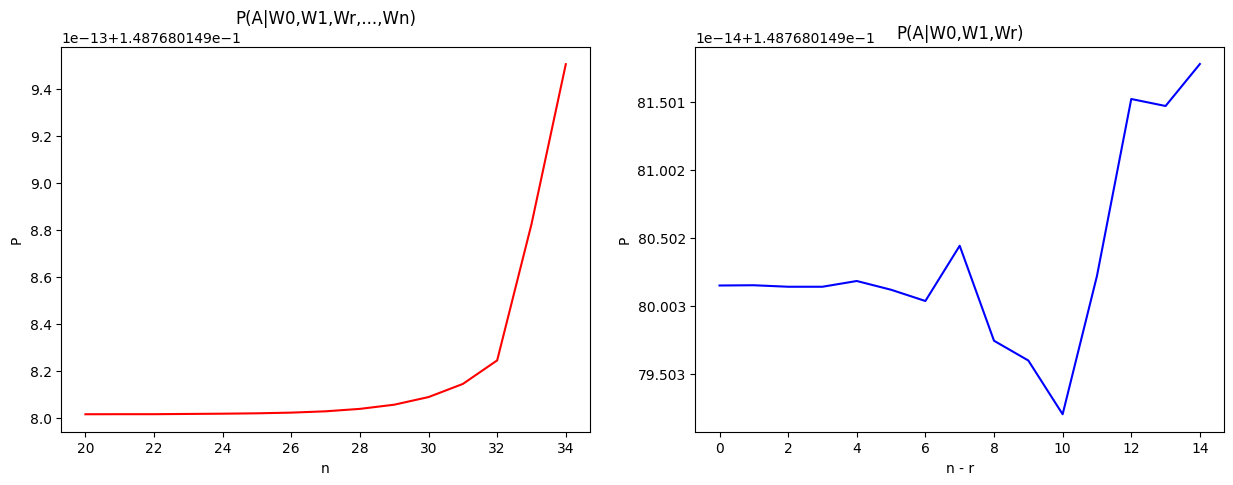

In [41]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15,5)

axs[0].plot(xn_p, [p[2] for p in ps_n], color = 'r')
axs[0].set_title("P(A|W0,W1,Wr,...,Wn)")
axs[0].set_xlabel("n")
axs[0].set_ylabel("P")


axs[1].plot([n-20 for n in xn_p], [p[2] for p in ps_rn], color = 'b')
axs[1].set_title("P(A|W0,W1,Wr)")
axs[1].set_xlabel("n - r")
axs[1].set_ylabel("P")
plt.show()

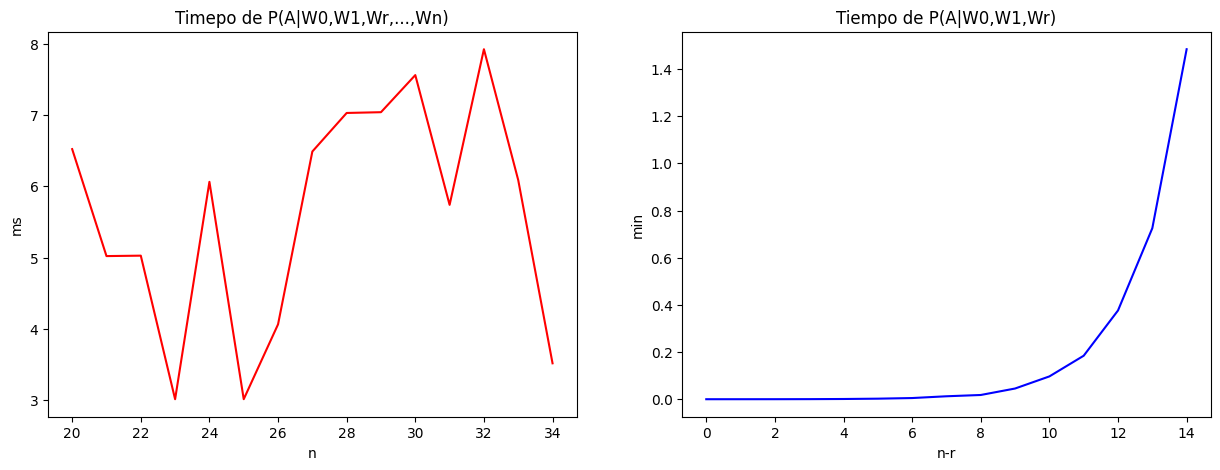

In [47]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15,5)

axs[0].plot(xn_p, [t * 1000 for t in t_ps_n], color = 'r',label = "Como decisión")
axs[0].set_title("Timepo de P(A|W0,W1,Wr,...,Wn)")
axs[0].set_xlabel("n")
axs[0].set_ylabel("ms")


axs[1].plot([n-20 for n in xn_p], [t/60 for t in t_ps_rn], color = 'b', label = "Con división")
axs[1].set_title("Tiempo de P(A|W0,W1,Wr)")
axs[1].set_xlabel("n-r")
axs[1].set_ylabel("min")
plt.show()

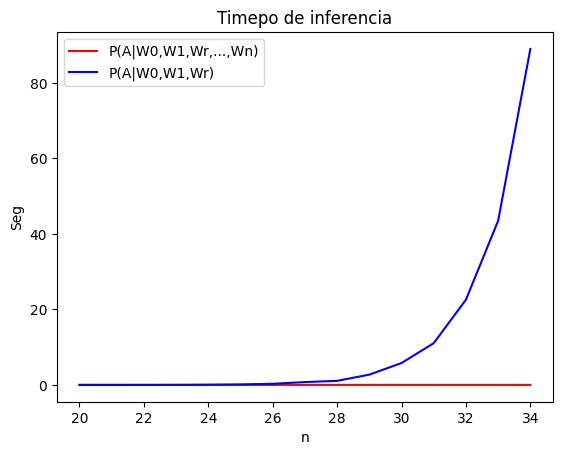

In [43]:
fig, ax = plt.subplots()

ax.plot(xn_p, t_ps_n, color = 'r', label = 'P(A|W0,W1,Wr,...,Wn)')
ax.plot(xn_p, t_ps_rn, color = 'b', label = 'P(A|W0,W1,Wr)')

ax.set_title("Timepo de inferencia")
ax.set_xlabel("n")
ax.set_ylabel("Seg")
ax.legend()

plt.show()

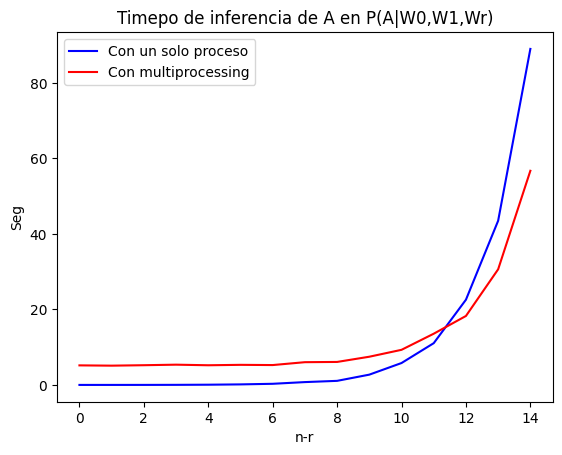

In [46]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

nmr = [n-20 for n in xn_p]
ax.plot(nmr, t_ps_rn, color = 'b', label = "Con un solo proceso")
ax.plot(nmr, t_ps_rn_mp, color = 'r', label = "Con multiprocessing")

ax.set_title("Timepo de inferencia de A en P(A|W0,W1,Wr)")
ax.set_xlabel("n-r")
ax.set_ylabel("Seg")
ax.legend()

plt.show()